# APLICAÇÃO DA ANÁLISE DE SENTIMENTOS NO TWITTER SOBRE A QUARTA ONDA DO COVID-19

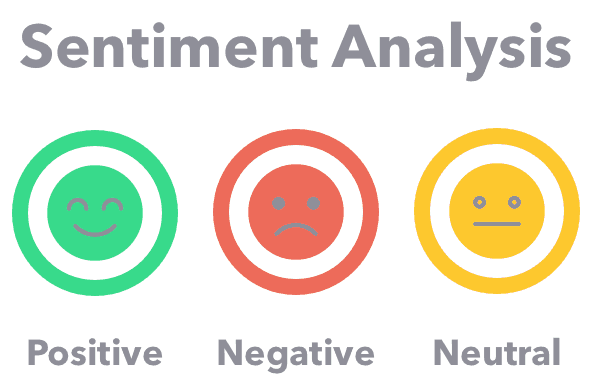

# 1. PREPARANDO O AMBIENTE 

1.1. IMPORTANDO BIBLIOTECA

In [12]:
import numpy as np #algebra linear
import pandas as pd #processamento de dados (e.g.pd.read_csv)
import re #for regex
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score
import pickle

1.2. CARREGANDO BASE DE DADOS/LER DADOS

In [13]:
data = pd.read_csv('C:/Users/Samara Viana Costa/OneDrive/Área de Trabalho/dados_classificados.csv')  
print(data.shape)
data.head()

(443, 8)


,Unnamed: 0,id,author_id,created_at,lang,text,classific,score
0,0,1,16.30789806,2022-06-15 21:23:53+00:00,pt,Pandemia acelerou transformação digital da mão...,neutro,0.559524
1,1,2,30.12152731,2022-06-15 21:23:51+00:00,pt,não tenho estrutura nenhuma pra minha gata com...,neutro,0.500000
2,2,3,60.11008242,2022-06-15 21:23:49+00:00,pt,RT @g_garc2: Tempos estranhos...;;;,neutro,0.500000
3,3,4,-,-,pt,Pandemia politicamente correta. ;;;,neutro,0.500000
4,4,5,-,-,pt,"A que ponto chegamos! https://t.co/Yg9bwd6tog"";;;",neutro,0.500000


In [3]:
#Filtrar a categoria "Neutro"
#data=data[data.classific!='neutro']

In [14]:
#Verificando informações de 'nº' e 'nº de variáveis'
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443 entries, 0 to 442
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  443 non-null    int64  
 1   id          443 non-null    int64  
 2   author_id   443 non-null    object 
 3   created_at  443 non-null    object 
 4   lang        443 non-null    object 
 5   text        443 non-null    object 
 6   classific   443 non-null    object 
 7   score       443 non-null    float64
dtypes: float64(1), int64(2), object(5)
memory usage: 27.8+ KB


# 2. ANÁLISE DESCRITIVA DOS DADOS

In [15]:
#frequencia Classificação
data.classific.value_counts()

neutro      298
positivo     85
negativo     60
Name: classific, dtype: int64

<AxesSubplot:>

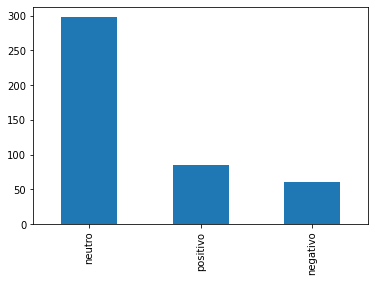

In [16]:
#Gráfico - Classificação
%matplotlib inline
data.classific.value_counts().plot(kind='bar')

# 3. PRE-PROCESSAMENTO DOS DADOS

1. Remove Stopwords
2. Lematização
3. Remove caracteres indesejados como links etc.

# 3.1. Funções de Pre-processamento de dados

# 3.1.1. Limpeza dos Dados

3.1.1.1. Remover HTML, TAGS,  Regex:'<,*?>'

In [20]:
def clean(text):
    cleaned = re.compile(r'<.*?>')
    return re.sub(cleaned, '',text)
data.text = data.text.apply(clean)
data.text[0]

'Pandemia acelerou transformação digital da mão de obra do trabalho, diz especialista https://t.co/at6xYjNRPG https://t.co/v73oHIZJ5x'

3.1.1.2. Removendo Caractes Especiais

In [25]:
def is_special(text):
    rem = ''
    for i in text:
        if i.isalnum():
            rem = rem + i
        else:
            rem = rem + ' '
    return rem

data.text = data.text.apply(is_special)
data.text[0]

'Pandemia acelerou transformação digital da mão de obra do trabalho  diz especialista https   t co at6xYjNRPG https   t co v73oHIZJ5x'

3.1.1.3. Convertendo Tudo para Minúsculas (eliminando letras maiúsculas para não dar pesos diferentes para a mesma coisa)

In [26]:
def to_lower(text):
    return text.lower()

data.text = data.text.apply(to_lower)
data.text[0]

'pandemia acelerou transformação digital da mão de obra do trabalho  diz especialista https   t co at6xyjnrpg https   t co v73ohizj5x'

# 3.1.2. Tokenização

Removendo Stopwords (contagem de palavras que traz algum significado - eliminando palavras que não tras nada. e.g: artigos...). Atente para o tipo de dados que você está trabalhando.

In [27]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

def rem_stopwords(text):
    stop_words = set(stopwords.words('portuguese'))
    words = word_tokenize(text)
    return [w for w in words if w not in stop_words]

data.text = data.text.apply(rem_stopwords)
data.text[0]

[nltk_data] Downloading package stopwords to C:\Users\Samara Viana
[nltk_data]     Costa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Samara Viana
[nltk_data]     Costa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['pandemia',
 'acelerou',
 'transformação',
 'digital',
 'mão',
 'obra',
 'trabalho',
 'diz',
 'especialista',
 'https',
 't',
 'co',
 'at6xyjnrpg',
 'https',
 't',
 'co',
 'v73ohizj5x']

# 3.1.3. lematização

In [28]:
def Stemming(text):
    stemmer = nltk.stem.RSLPStemmer()
    words = []
    for w in text.split():
        words.append(stemmer.stem(w))
    return (" ".join(words))

# 4. CRIAÇÃO DO MODELO 

x = np.array(data.iloc[:,0].values)
y = np.array(data.classific.values)
cv = CountVectorizer(max_features = 1000)
x = cv.fit_transform(data.text).toarray()
print("x.shape = ",x.shape)
print("y.shape = ",y.shape)

trainx,testx,trainy,testy = train_test_split(x,y,test_size=0.2,random_state=9)
print("Train shapes : x = {}, y = {}".format(trainx.shape,trainy.shape))
print("Test shapes : x = {}, y = {}".format(testx.shape,testy.shape))

gnb,mnb,bnb = GaussianNB(),MultinomialNB(alpha=1.0, fit_prior=True), BernoulliNB(alpha=1.0,fit_prior=True)
gnb.fit(trainx,trainy)
mnb.fit(trainx,trainy)
bnb.fit(trainx,trainy)

ypg = gnb.predict(testx)
ypm = mnb.predict(testx)
ypb = bnb.predict(testx)